In [1]:
from pytorch_variational_autoencoder import *
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from scipy.stats import norm
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid as make_image_grid
from tqdm import tnrange

In [2]:
# Data loaders
trainloader = DataLoader(
    MNIST(root=str(Path.home()) + '/Documents/datasets/mnist',train=True,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)
testloader = DataLoader(
    MNIST(root=str(Path.home()) + '/Documents/datasets/mnist',train=False,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)

In [3]:
# loading the model
model = VAE()
model.load_state_dict(torch.load('model.pkl'))

In [4]:
# Visualize moving average of losses
def visualize_losses_moving_average(losses,window=50,boundary='valid',ylim=(95,125)):
    mav_losses = np.convolve(losses,np.ones(window)/window,boundary)
    corrected_mav_losses = np.append(np.full(window-1,np.nan),mav_losses)
    plt.figure(figsize=(10,5))
    plt.plot(losses)
    plt.plot(corrected_mav_losses)
    plt.ylim(ylim)
    plt.show()

In [5]:
def test(model,dataloader):
    running_loss = 0.0
    for images, _ in dataloader:
        x_in = Variable(images)
        x_out, z_mu, z_logvar = model(x_in)
        loss = criterion(x_out,x_in,z_mu,z_logvar)
        running_loss = running_loss + (loss.data[0]*x_in.size(0))
    return running_loss/len(dataloader.dataset)

test_loss = test(model,test_loader)
print(test_loss)

107.37563592529297


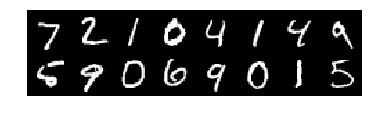

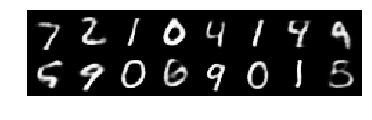

In [6]:
# Visualize VAE input and reconstruction
def visualize_mnist_vae(model,dataloader,num=16):
    def imshow(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg,(1,2,0)))
        plt.axis('off')
        plt.show()
        
    images,_ = iter(dataloader).next()
    images = images[0:num,:,:]
    x_in = Variable(images)
    x_out,_,_ = model(x_in)
    x_out = x_out.data
    imshow(make_image_grid(images))
    imshow(make_image_grid(x_out))

visualize_mnist_vae(model,test_loader)

# Train, test and visualize reconstruction using a 2D latent space


Widget Javascript not detected.  It may not be installed or enabled properly.


Epoch: [1/5], Iter: [100/469] loss: 194.7482452392578
Epoch: [1/5], Iter: [200/469] loss: 180.83590698242188
Epoch: [1/5], Iter: [300/469] loss: 176.02178955078125
Epoch: [1/5], Iter: [400/469] loss: 175.27151489257812
Epoch: [2/5], Iter: [100/469] loss: 168.39195251464844
Epoch: [2/5], Iter: [200/469] loss: 161.0999755859375
Epoch: [2/5], Iter: [300/469] loss: 165.665283203125
Epoch: [2/5], Iter: [400/469] loss: 160.43701171875
Epoch: [3/5], Iter: [100/469] loss: 155.30567932128906
Epoch: [3/5], Iter: [200/469] loss: 165.4288330078125
Epoch: [3/5], Iter: [300/469] loss: 166.00115966796875
Epoch: [3/5], Iter: [400/469] loss: 159.44778442382812
Epoch: [4/5], Iter: [100/469] loss: 163.48861694335938
Epoch: [4/5], Iter: [200/469] loss: 151.04222106933594
Epoch: [4/5], Iter: [300/469] loss: 162.6533966064453
Epoch: [4/5], Iter: [400/469] loss: 157.82083129882812
Epoch: [5/5], Iter: [100/469] loss: 156.89910888671875
Epoch: [5/5], Iter: [200/469] loss: 159.4738006591797
Epoch: [5/5], Iter: 

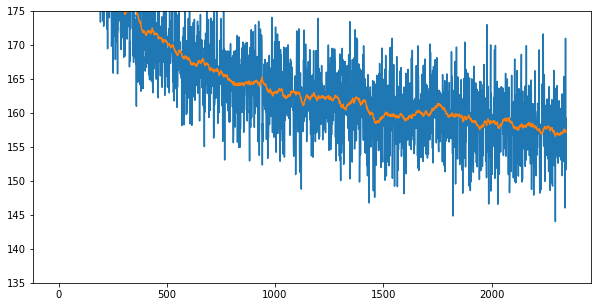

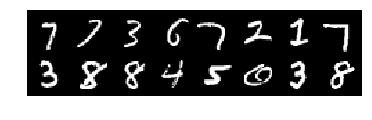

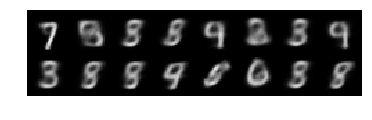

In [7]:
model2 = VAE(latent_dim=2)
optimizer2 = torch.optim.Adam(model2.parameters())

train2_losses = train(model2,optimizer2,trainloader)
test2_loss = test(model2,testloader)

print(test2_loss)
visualize_losses_moving_average(train2_losses,ylim=(135,175))
visualize_mnist_vae(model2,testloader)

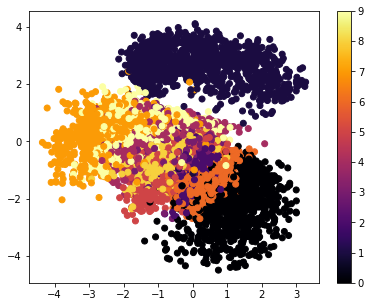

In [8]:
# Visualize test data encodings on the latent space
def visualize_encoder(model,dataloader):
    z_means_x, z_means_y, all_labels = [], [], []
    
    for images,labels in iter(dataloader):
        z_means,_ = model.encoder(Variable(images))
        z_means_x = np.append(z_means_x,z_means[:,0].data.numpy())
        z_means_y = np.append(z_means_y,z_means[:,1].data.numpy())
        all_labels = np.append(all_labels,labels.numpy())
        
    plt.figure(figsize=(6.5,5))
    plt.scatter(z_means_x,z_means_y,c=all_labels,cmap='inferno')
    plt.colorbar()
    plt.show()

visualize_encoder(model2,testloader)

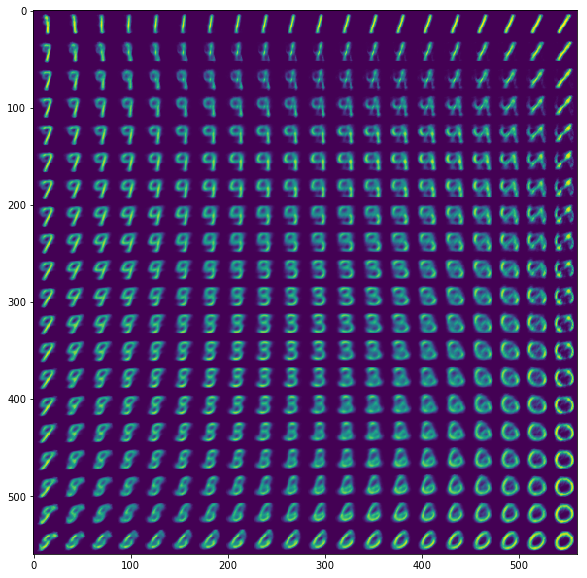

In [9]:

# Visualize digits generated from latent space grid
def visualize_decoder(model,num=20,range_type='g'):
    image_grid = np.zeros([num*28,num*28])

    if range_type == 'l': # linear range
        # corresponds to output range of visualize_encoding()
        range_space = np.linspace(-4,4,num)
    elif range_type == 'g': # gaussian range
        range_space = norm.ppf(np.linspace(0.01,0.99,num))
    else:
        range_space = range_type

    for i, x in enumerate(range_space):
        for j, y in enumerate(reversed(range_space)):
            z = Variable(torch.FloatTensor([[x,y]]))
            image = model.decoder(z)
            image = image.data.numpy()
            image_grid[(j*28):((j+1)*28),(i*28):((i+1)*28)] = image

    plt.figure(figsize=(10, 10))
    plt.imshow(image_grid)
    plt.show()

visualize_decoder(model2)